In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

import seaborn as sns

In [186]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error, r2_score # подгружаем метрику mse и r2
from sklearn.metrics import precision_score, recall_score

<p style="align: center;"><img align=center src="https://netology.ru/backend/tilda/images/tild3439-3364-4535-b334-656263633534__main.svg"  width=900></p>
<h3 style="text-align: center;"><b>Функции потери и оптимизация</b></h3>

#  Домашнее задание

### Задание  
    
В домашнем задании необходимо применить полученные знания в теории оптимизации и машинном обучении для реализации логистической регрессии.


1. Загрузите данные. Используйте датасет с ирисами. Его можно загрузить непосредственно из библиотеки Sklearn. В данных оставьте только 2 класса: Iris Versicolor, Iris Virginica.
2. Самостоятельно реализуйте логистическую регрессию, без использования метода LogisticRegression из библиотеки. Можете использовать библиотеки pandas, numpy, math для реализации. Оформите в виде функции. *Оформите в виде класса с методами.
3. Реализуйте метод градиентного спуска. Обучите логистическую регрессию этим методом. Выберете и посчитайте метрику качества. Метрика должна быть одинакова для всех пунктов домашнего задания. Для упрощения сравнения выберете только одну метрику.
4. Повторите п. 3 для метода скользящего среднего (Root Mean Square Propagation, RMSProp).
5. Повторите п. 3 для ускоренного по Нестерову метода адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).
6. Сравните значение метрик для реализованных методов оптимизации. Можно оформить в виде таблицы вида |метод|метрика|время работы| (время работы опционально). Напишите вывод.

In [95]:
iris = load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

##### Классы

    "0": setosa
    "1": versicolor
    "2": virginica
    
Оставляем только 2 класса: Iris Versicolor "1", Iris Virginica "2".

In [96]:
filter = y != 0

X = X[filter]
y = y[filter]

print(X.shape, y.shape)
y

(100, 4) (100,)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [97]:
# Заменим в target 'versicolor' = 0, 'virginica' = 1
y = np.where(y==1, 0,1)

y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [98]:
X.dtype

dtype('float64')

### Логистическая регрессия
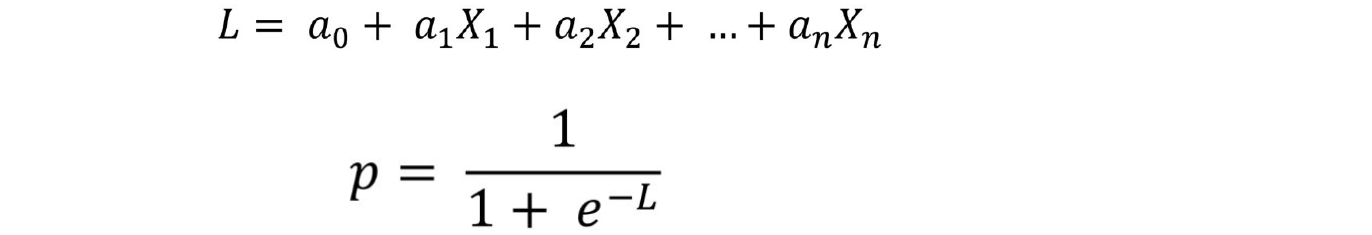

#### Метод стохастического градиентного спуска

In [99]:
def sigmoid(x, params):  
    
    return 1 / (1 + np.exp(-(params[0] + 
                                        params[1] * x[0] + 
                                        params[2] * x[1] + 
                                        params[3] * x[2] + 
                                        params[4] * x[3])))

In [182]:
def predict_class(predictions):
    return list(map(lambda x: 1 if x >0.6 else 0, predictions))

In [204]:
def learn_sgd(X, y, num_epochs=6000, learning_rate=0.0001):
    np.random.seed(43)
    costs = []
    params = []
    params = np.random.normal(size=(5,))
    print(f'Params:     {params}')
    for _ in range(num_epochs):
        predictions = []
        for j, v in enumerate(X):

            predict = sigmoid(v, params)
            predictions.append(predict)

        cost = np.sum(np.square(predictions - y)) / (2 * len(predictions))
        costs.append(cost)

        i = np.random.choice(len(X))
        current_prediction = sigmoid(X[i], params)

        params[0] -= learning_rate * (current_prediction - y[i]) 
        params[1] -= learning_rate * ((current_prediction - y[i]) * X[i][0])
        params[2] -= learning_rate * ((current_prediction - y[i]) * X[i][1])
        params[3] -= learning_rate * ((current_prediction - y[i]) * X[i][2])
        params[4] -= learning_rate * ((current_prediction - y[i]) * X[i][3])
        
    class_predictions = predict_class(predictions)
    return costs, params, class_predictions

In [205]:
costs, new_params, preds = learn_sgd(X, y)
print(f'New params: {new_params}')

Params:     [ 0.25739993 -0.90848143 -0.37850311 -0.5349156   0.85807335]
New params: [ 0.34098149 -0.29179776 -0.11130552  0.04991358  1.08849094]


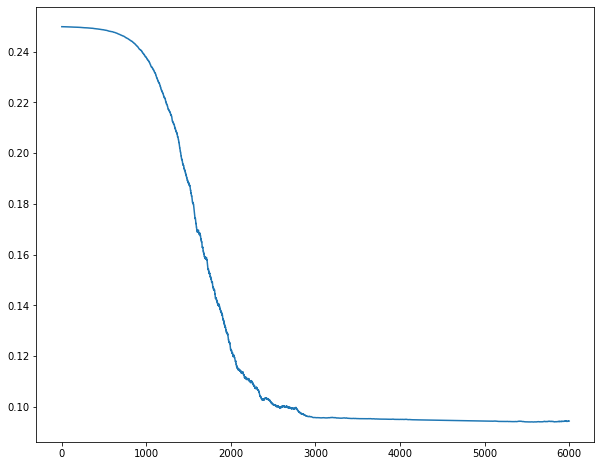

In [203]:
plt.figure(figsize=(10,8))
plt.plot(costs)
plt.show()

#### Оценки качества классификации

In [187]:
# Точность
accuracy_score(y, preds)

0.84

In [188]:
# Площадь под ROC-кривой
roc_auc_score(y, preds)

0.84

#### метод скользящего среднего (Root Mean Square Propagation, RMSProp)

In [260]:
def learn_rmsprop(X, y, num_epochs=500, learning_rate=0.01):    
    num_epochs = 500
    learning_rate = 0.01
    momentum = 0.9
    epsilon = 10e-6

    costs = []
    params = []
    

    params = np.random.normal(size=(5,))
    E = np.random.normal(size=(5,))

    for _ in range(num_epochs):
        predictions = []
        for j, v in enumerate(X):

            predict = sigmoid(v, params)
            predictions.append(predict)
     
        E[0] = momentum * np.mean(np.square(np.sum((predictions - y) * X[:,0]) / len(predictions))) + (1 - momentum) * (np.square(np.sum((predictions - y) * X[:,0]) / len(predictions)))
        E[1] = momentum * np.mean(np.square(np.sum((predictions - y) * X[:,1]) / len(predictions))) + (1 - momentum) * (np.square(np.sum((predictions - y) * X[:,1]) / len(predictions)))
        E[2] = momentum * np.mean(np.square(np.sum((predictions - y) * X[:,2]) / len(predictions))) + (1 - momentum) * (np.square(np.sum((predictions - y) * X[:,2]) / len(predictions)))
        E[3] = momentum * np.mean(np.square(np.sum((predictions - y) * X[:,3]) / len(predictions))) + (1 - momentum) * (np.square(np.sum((predictions - y) * X[:,3]) / len(predictions)))

        params[0] -= learning_rate * (np.sum(predictions - y) / len(predictions))
        params[1] -= learning_rate * (np.sum((predictions - y) * X[:,0]) / len(predictions)) / np.sqrt(E[0] + epsilon) 
        params[2] -= learning_rate * (np.sum((predictions - y) * X[:,1]) / len(predictions)) / np.sqrt(E[1] + epsilon) 
        params[3] -= learning_rate * (np.sum((predictions - y) * X[:,2]) / len(predictions)) / np.sqrt(E[2] + epsilon) 
        params[4] -= learning_rate * (np.sum((predictions - y) * X[:,3]) / len(predictions)) / np.sqrt(E[3] + epsilon)
            
        cost = np.sum(np.square(predictions - y)) / (2 * len(predictions))
        costs.append(cost)
        
    class_predictions = predict_class(predictions)
    return costs, params, class_predictions

In [269]:
costs_1, params_1, preds_1 = learn_rmsprop(X, y)
print(f'New params: {params_1}')

New params: [-1.22899231 -1.55003383 -2.53390703  2.61759748  3.247819  ]


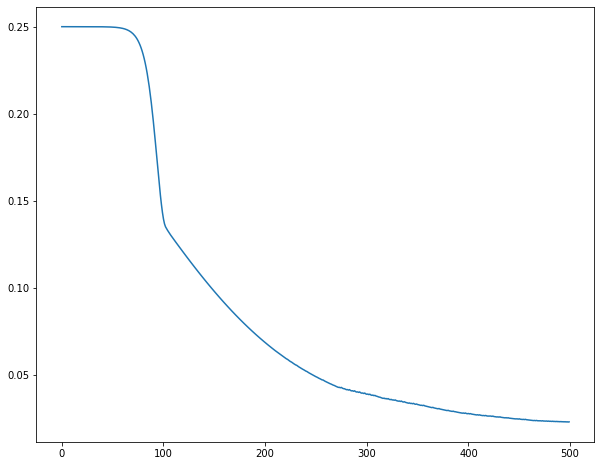

In [270]:
plt.figure(figsize=(10,8))
plt.plot(costs_1)
plt.show()

#### Оценки качества классификации RMSprop

In [271]:
# Точность
accuracy_score(y, preds_1)

0.96

In [272]:
# Площадь под ROC-кривой
roc_auc_score(y, preds_1)

0.96

Повторите п. 3 для ускоренного по Нестерову метода адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).

### Выводы:
       
Наилучший результат оптимизации показал метод RMSprop, что доказывают метрики качества модели. Так же хорошего результата получилось добиться за гораздо меньше итераций.



P.S.  Оптимизацию методом Nadam, не реализовала ввиду сложности метода